In [1]:
# Load libraries
import sympy
import numpy as np
from collections import namedtuple
import pandas as pd
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow import keras
from sklearn.model_selection import train_test_split

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

2022-08-08 16:46:03.888546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 16:46:03.888587: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-08 16:46:05.656554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-08 16:46:05.656608: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-08 16:46:05.656642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Enigma): /proc/driver/nvidia/version does not exist
2022-08-08 16:46:05.656937: I tensorflow/core/platform/cpu_feature_gua

### Experimental setup

In [11]:
# Specify data path
path = "../data/gtzan_30s_stats.csv"
# Specify genres to build classification model from, options are:
# blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock 
target_pair = ["rock", "reggae"]

In [12]:
# Create a Sample
Samples = namedtuple("Samples", ["X_train", "y_train", "X_test", "y_test"])
raw = pd.read_csv(path)
target = "label"
columns_to_remove = ["filename", "length", target]
y = raw.loc[:, target]
X = raw.drop(columns_to_remove, axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)
samples = Samples(X_train, y_train, X_test, y_test)


train_filter = np.where(
    (samples.y_train == target_pair[0]) | (samples.y_train == target_pair[1])
)
test_filter = np.where(
    (samples.y_test == target_pair[0]) | (samples.y_test == target_pair[1])
)
X_train_filtered, X_test_filtered = (
    samples.X_train.iloc[train_filter],
    samples.X_test.iloc[test_filter],
)
y_train_filtered, y_test_filtered = (
    samples.y_train.iloc[train_filter],
    samples.y_test.iloc[test_filter],
)

y_train_filtered = np.where(y_train_filtered == target_pair[1], 1, 0)
y_test_filtered = np.where(y_test_filtered == target_pair[1], 1, 0)

samples_filtered = Samples(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered
)

### Setup a preprocessing pipeline

In [13]:
# features = [
#     "rolloff_var",
#     "mfcc1_var",
#     "mfcc4_var",
#     "mfcc5_var",
#     "mfcc8_var",
#     "mfcc9_mean",
#     "mfcc11_var",
#     "mfcc13_mean",
# ]
features = ['mfcc2_var', 'mfcc3_var', 'mfcc4_var', 'mfcc5_var', 'mfcc7_var',
       'mfcc8_var', 'mfcc11_mean', 'mfcc13_mean']
#['spectral_bandwidth_var', 'mfcc3_var', 'mfcc4_var', 'mfcc5_var', 'mfcc6_var', 'mfcc7_var', 'mfcc8_var', 'mfcc10_var']

X_train_selected = np.array(samples_filtered.X_train[features])
X_test_selected = np.array(samples_filtered.X_test[features])

samples_selected = Samples(
    X_train_selected, y_train_filtered, X_test_selected, y_test_filtered
)

# def qubit_encoding(inputs, gate=cirq.rx):
#     # Scale each column between 0 and 1
#     inputs_0_1 = tf.divide(
#         tf.subtract(inputs, tf.reduce_min(inputs, axis=0)),
#         tf.subtract(tf.reduce_max(inputs, axis=0), tf.reduce_min(inputs, axis=0)),
#     )
#     # Scale between 0 and 2pi
#     inputs_0_2pi = tf.multiply(inputs_0_1, 2 * np.pi)
#     # Encode each row as a circuit
#     inputs_circuit = []
#     for x in inputs_0_2pi:
#         circuit = cirq.Circuit()
#         for i, value in enumerate(x):
#             qubit = cirq.LineQubit(i)
#             circuit.append(gate(value.numpy()).on(qubit))
#         inputs_circuit.append(circuit)
#     return tfq.convert_to_tensor(inputs_circuit)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

scaler = scaler = (
    "minmax",
    preprocessing.MinMaxScaler(feature_range=[0, np.pi / 2]),
)
# selection = selection = (
#     "tree",
#     SelectFromModel(
#         ExtraTreesClassifier(n_estimators=50),
#         max_features=8,
#     ),
# )

pipeline = Pipeline([scaler])
pipeline.fit(samples_selected.X_train, samples_selected.y_train)

# Transform data
X_train_tfd = pipeline.transform(samples_selected.X_train)
X_test_tfd = pipeline.transform(samples_selected.X_test)
samples_tfd = Samples(
    X_train_tfd, samples_selected.y_train, X_test_tfd, samples_selected.y_test
)



### Encode data to a quantum state

In [14]:
def qubit_encoding(x):
    circuit = cirq.Circuit()
    for i, value in enumerate(x):
        qubit = cirq.LineQubit(i)
        circuit.append(cirq.rx(x[i]).on(qubit))

    return circuit  

X_train_encoded = tfq.convert_to_tensor([qubit_encoding(x) for x in samples_tfd.X_train])
X_test_encoded = tfq.convert_to_tensor([qubit_encoding(x) for x in samples_tfd.X_test])

samples_encoded = Samples(
    X_train_encoded, samples_tfd.y_train, X_test_encoded, samples_tfd.y_test
)


### Build model

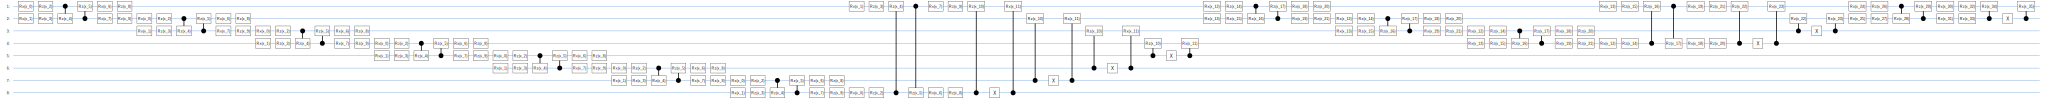

In [26]:
from cirq.contrib.svg import SVGCircuit
qcnn = Qcnn()
SVGCircuit(qcnn.circuit)

In [41]:
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    # circuit += cirq.H(q0)
    # circuit += cirq.H(q1)
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    # circuit += cirq.rz(symbols[1]).on(q0).controlled_by(q1)
    return circuit


def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.CNOT(q0, q1)
    return circuit

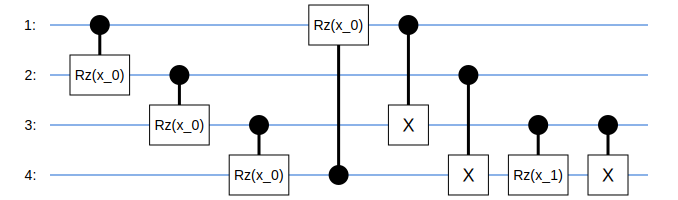

In [54]:
qcnn = Qcnn(n_q=4, s_c=1, s_p=0, pool_filter="left", convolution_mapping={1: (U, 1)}, pooling_mapping={1: (V, 0)})
SVGCircuit(qcnn.circuit)

In [55]:
qcnn.readout

cirq.LineQubit(4)

Scale up model to 16 qubits

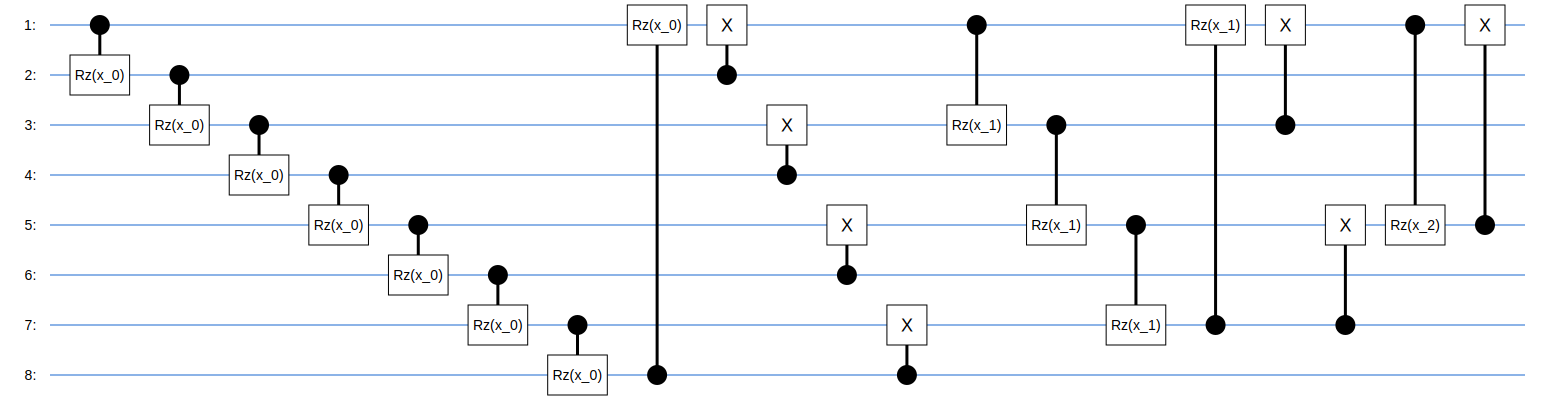

In [47]:
qcnn = Qcnn(n_q=8, s_c=1, s_p=0, pool_filter="odd", convolution_mapping={1: (U, 1)}, pooling_mapping={1: (V, 0)})
SVGCircuit(qcnn.circuit)

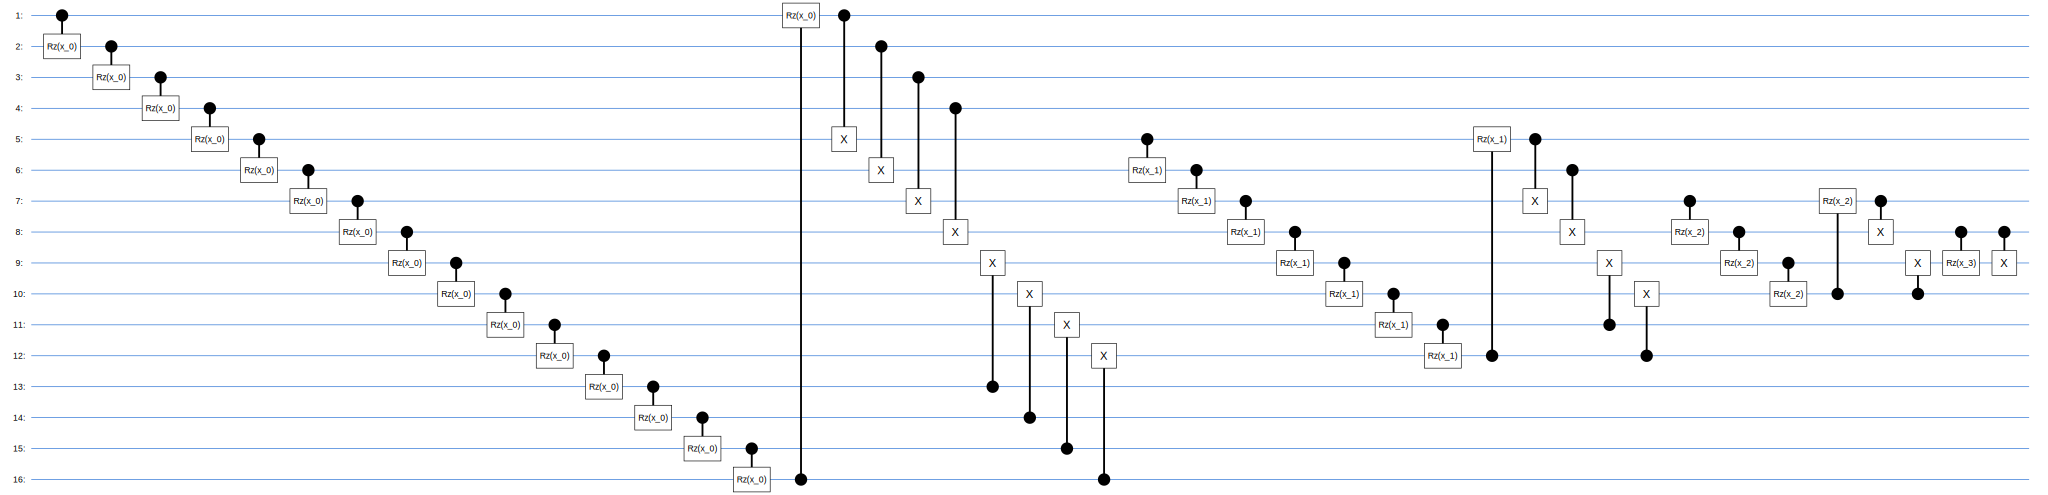

In [52]:
qcnn = Qcnn(n_q=16, s_c=1, s_p=0, pool_filter="outside", convolution_mapping={1: (U, 1)}, pooling_mapping={1: (V, 0)})
SVGCircuit(qcnn.circuit)

In [15]:
from quantum_estimators import Qcnn
# === Specify hyperparamaters ===
# Number of qubits (since we're using qubit encoding ensure there is a one-one mapping between feature and qubit)
n_q = 8
# Convolution Stride
s_c = 1
# Pooling Stride
s_p = 0
# Pooling Filter, options: right, left, inside, outside, even, odd
pool_filter = "right"
model = tf.keras.Sequential(
        [
            # The Qcnn layer returns the expected value of the readout gate, range [-1,1]. By default readout is criq.Z and the model determines
            # which qubit to measure based on the one that's left over
            Qcnn(
                n_q=8,
                s_c=s_c,
                s_p=s_p,
                pool_filter=pool_filter,
            ),
            # Convert expectation values to lie between 0 and 1
            tf.keras.layers.Rescaling(1.0 / 2, offset=.5),
        ]
    )

1: ───Rx(x_0)───Rz(x_2)───@─────────Rz(x_5)───Rx(x_6)───Rz(x_8)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(x_1)───Rz(x_3)───Rz(x_4)───@─────────Rx(x_7)───Rz(x_9)───Rz(x_10)───────Rx(x_11)─────────────────────────────────────────────────────────────────────────────────Rx(x_12)───Rz(x_14)───@──────────Rz(x_17)───Rx(x_18)───Rz(x_20)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(x_13)───Rz(x_15)───Rz(x_16)───@──────────Rx(x_19)───Rz(x_21)───Rz(x_22)───────Rx(x_23)─────────────────────────────Rx(x_24)───Rz(x_26)───@──────────Rz(x_29)───Rx(x_30)───Rz(x_32)───Rz(x_34)───────Rx(x_35)───
                          │         │                                                                                                                                                                                                                                                                                                                                                                                                                         │         │                             │              │                                                                                                              │          │                                                                                                                                                                                          │          │                                │              │                                                          │          │                                │              │
2: ───Rx(x_1)───Rz(x_3)───Rz(x_4)───@─────────Rx(x_7)───Rz(x_9)───Rx(x_0)───Rz(x_2)───@─────────Rz(x_5)───Rx(x_6)───Rz(x_8)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┼─────────────────────────────┼──────────────┼──────────Rz(x_10)───────Rx(x_11)───────────────────────────────────────────────────────Rx(x_13)───Rz(x_15)───Rz(x_16)───@──────────Rx(x_19)───Rz(x_21)───Rx(x_12)───Rz(x_14)───@──────────Rz(x_17)───Rx(x_18)───Rz(x_20)───────────────────────────────────────────────────────────────────────────────────────────┼──────────┼────────────────────────────────┼──────────────┼──────────Rz(x_22)───────Rx(x_23)───Rx(x_25)───Rz(x_27)───Rz(x_28)───@──────────Rx(x_31)───Rz(x_33)───@──────────X───@──────────
                                                                                      │         │                                                                                                                                                                                                                                                                                                                                                             │         │                             │              │          │              │                                                                                                                                                      │          │                                                                                                                        │          │                                │              │          │              │
3: ───────────────────────────────────────────────────────────────Rx(x_1)───Rz(x_3)───Rz(x_4)───@─────────Rx(x_7)───

In [ ]:
from quantum_estimators import Qcnn
# from quantum_estimators.cirq_qcnn import Qcnn

def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.H(q0)
    circuit += cirq.H(q1)
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    circuit += cirq.rz(symbols[1]).on(q0).controlled_by(q1)
    return circuit


def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.CNOT(q0, q1)
    return circuit

import itertools as it
# s_c = 1
# s_p = 3
# pool_filter = "right"
results = []
for s_c, s_p, pool_filter in it.product(
    [1, 3, 5, 7],
    [0, 1, 2, 3],
    ["right", "left", "even", "odd", "inside", "outside"],
):
    for rep in range(10):
        model = tf.keras.Sequential(
            [
                # The PQC layer returns the expected value of the readout gate, range [-1,1].
                Qcnn(
                    n_q=8,
                    s_c=s_c,
                    s_p=s_p,
                    pool_filter=pool_filter,
                    # convolution_mapping={1: (U, 2)},
                    # pooling_mapping={1: (V, 0)},
                ),
                # Scale expectation values between 0 and 1
                tf.keras.layers.Rescaling(1.0 / 2, offset=.5),
            ]
        )
        model.compile(
            optimizer="Adam",
            loss="binary_crossentropy",
            metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
        )
        # model.run_eagerly = True
        model.fit(x=samples_encoded.X_train, y=samples_encoded.y_train, epochs=100)

### Evaluate

In [ ]:
model.summary()
# print(model.trainable_variables)

qcnn_results = model.evaluate(samples_encoded.X_test, samples_encoded.y_test)
results.append([f"{s_c}_{s_p}_{pool_filter}_{rep}", qcnn_results])
# print(qcnn_results)
print(results)
print("Stop here dont play")